# Мастерская

## Цель проекта

**Описание**: Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

**Цель проекта**: разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

## Исходные данные

**Исходные данные**:
- `train.csv` - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
- `test.csv` - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'music_genre' для каждого трека из этого датасета.
- `sample_submit.csv` - файл предсказаний в правильном формате.
- `instance_id` - идентификатор трека в тестовом наборе.
- `music_genre` - целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

Ссылка на соревнование: https://www.kaggle.com/t/086c585fc8974d4c93216956512ca40e

## 1. Загрузка и ознакомление с данными

### Импортирование библиотек:

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from catboost import CatBoostClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import phik
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных:

In [7]:
data_train= pd.read_csv('datasets/kaggle_music_genre_train.csv')
data_test= pd.read_csv('datasets/kaggle_music_genre_test.csv')

Вывод:
Мы импортируем необходимые библиотеки для обработки и анализа данных, включая pandas, sklearn, matplotlib, seaborn, numpy и catboost. Затем мы загружаем тренировочные и тестовые данные из файлов CSV.

## 2. Предобработка данных

### Замена пропущенных значений:

In [8]:
for column in ['tempo', 'key', 'mode']:
    data_train[column].fillna(data_train[column].median() if data_train[column].dtype == 'float64' else data_train[column].mode()[0], inplace=True)
    data_test[column].fillna(data_test[column].median() if data_test[column].dtype == 'float64' else data_test[column].mode()[0], inplace=True)

In [9]:
mean_duration = data_train[data_train['duration_ms'] != -1.0]['duration_ms'].mean()
data_train['duration_ms'] = data_train['duration_ms'].replace(-1.0, mean_duration)

mean_duration_test = data_test[data_train['duration_ms'] != -1.0]['duration_ms'].mean()
data_test['duration_ms'] = data_test['duration_ms'].replace(-1.0, mean_duration_test)

Вывод:
Мы обрабатываем пропущенные значения в столбцах 'tempo', 'key' и 'mode' в тренировочных и тестовых данных. Если тип данных столбца - 'float64', мы заменяем пропущенные значения медианным значением этого столбца. В противном случае мы используем моду (наиболее часто встречающееся значение).

Также мы обрабатываем аномальные значения в столбце 'duration_ms'. Если значение равно -1.0, что, вероятно, является маркером для пропущенных или неизвестных данных, мы заменяем его средним значением 'duration_ms' для всех других записей.

## 3. Полноценный разведочный анализ

In [10]:
print(data_train.head())

   instance_id                  track_name  acousticness  danceability  \
0      25143.0                  Highwayman        0.4800         0.670   
1      26091.0       Toes Across The Floor        0.2430         0.452   
2      87888.0       First Person on Earth        0.2280         0.454   
3      77021.0  No Te Veo - Digital Single        0.0558         0.847   
4      20852.0             Chasing Shadows        0.2270         0.742   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0     182653.0   0.351          0.017600   D     0.115   -16.842  Major   
1     187133.0   0.670          0.000051   A     0.108    -8.392  Minor   
2     173448.0   0.804          0.000000   E     0.181    -5.225  Minor   
3     255987.0   0.873          0.000003  G#     0.325    -4.805  Minor   
4     195333.0   0.575          0.000002   C     0.176    -5.550  Major   

   speechiness    tempo obtained_date  valence  music_genre  
0       0.0463  101.384         4-Apr    0

In [ ]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  int64  
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               20394 non-null  int64  
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              20394 non-null  int64  
 11  speechiness       20394 non-null  float64
 12  tempo             20394 non-null  float64
 13  obtained_date     20394 non-null  int64  
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  int64  
 16  tonality          20394 non-null  int64 

In [ ]:
print(data_train.describe())

        instance_id    track_name  acousticness  danceability   duration_ms  \
count  20394.000000  20394.000000  20394.000000  20394.000000  2.039400e+04   
mean   55973.846916  11399.853290      0.274783      0.561983  2.444568e+05   
std    20695.792545   6591.322209      0.321643      0.171898  1.036959e+05   
min    20011.000000      0.000000      0.000000      0.060000  1.550900e+04   
25%    38157.250000   5703.250000      0.015200      0.451000  1.960892e+05   
50%    56030.000000  11416.500000      0.120000      0.570000  2.351330e+05   
75%    73912.750000  17066.000000      0.470000      0.683000  2.660000e+05   
max    91758.000000  22886.000000      0.996000      0.978000  4.497994e+06   

             energy  instrumentalness           key      liveness  \
count  20394.000000      20394.000000  20394.000000  20394.000000   
mean       0.625276          0.159989      5.498333      0.198540   
std        0.251238          0.306503      3.511066      0.166742   
min        0

In [ ]:
print(data_train.isnull().sum())

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
tonality            0
high_tempo          0
dtype: int64


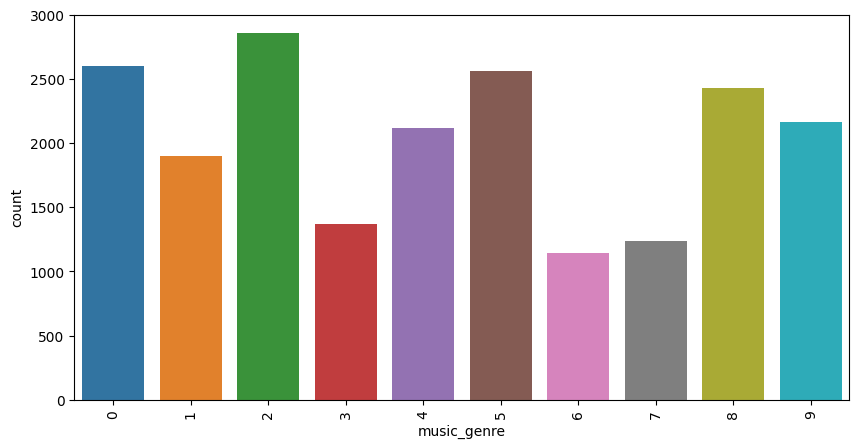

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=data_train, x='music_genre')
plt.xticks(rotation=90)
plt.show()

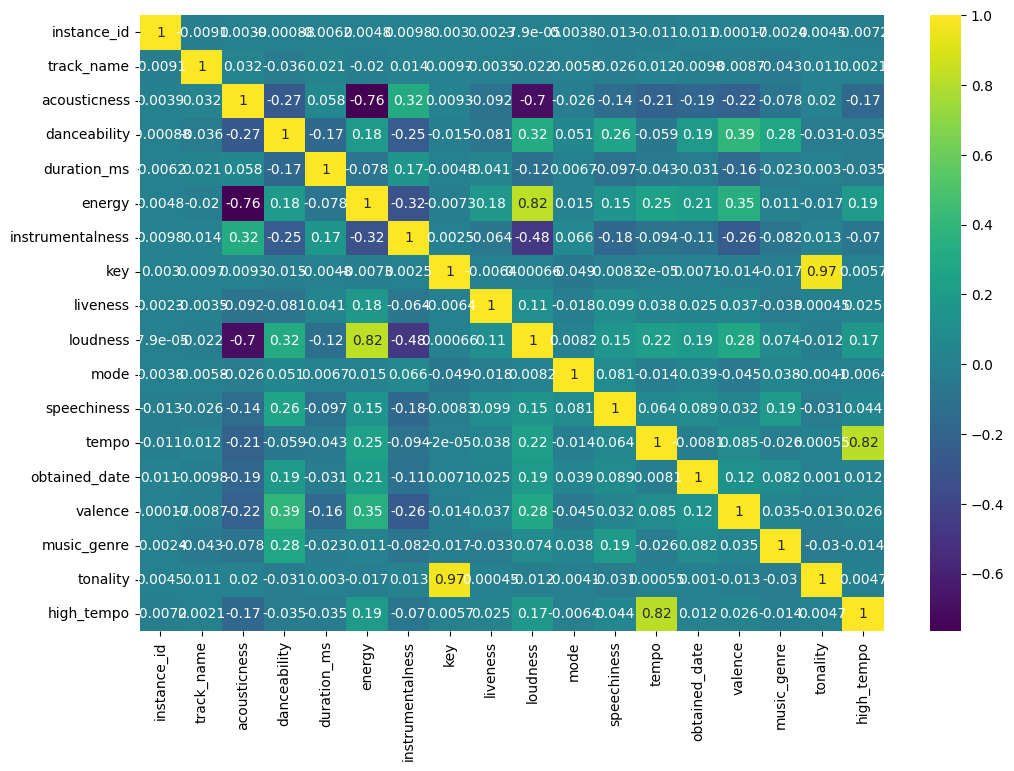

In [ ]:
data_train_numeric = data_train.select_dtypes(include=[np.number])

corr_metrics = data_train_numeric.corr()

# create a heatmap of the correlations
plt.figure(figsize=(12,8))
sns.heatmap(corr_metrics, annot=True, cmap='viridis')
plt.show()

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Красиво, но числа накладываются друг на друга, лучше округлять их </div>
    


Вывод:
Мы выводим информацию о наших данных, включая первые строки, информацию о столбцах, статистическую сводку и количество пропущенных значений. Затем мы строим график распределения музыкальных жанров и тепловую карту корреляций между числовыми столбцами. Это помогает нам понять распределение данных и связи между признаками.

## 4. Разработка новых синтетических признаков

### Создание признака 'tonality':

In [ ]:
def create_tonality_feature(df):
    data_train['tonality'] = data_train['key'].astype(str) + "_" + data_train['mode'].astype(str)
    return df

data_train = create_tonality_feature(data_train)


def create_tonality_feature_test(df):
    data_test['tonality'] = data_test['key'].astype(str) + "_" + data_test['mode'].astype(str)
    return df

data_test = create_tonality_feature_test(data_test)

### Создание признака 'high_tempo':

In [ ]:
data_train['high_tempo'] = (data_train['tempo'] > 120).astype(int)
data_test['high_tempo'] = (data_test['tempo'] > 120).astype(int)

### Кодирование категориальных признаков:

In [ ]:
le = LabelEncoder()

for column in ['tonality','key','mode','obtained_date', 'track_name']:
    le.fit(pd.concat([data_train[column], data_test[column]]))
    data_train[column] = le.transform(data_train[column])
    data_test[column] = le.transform(data_test[column])

le.fit(data_train['music_genre'])
data_train['music_genre'] = le.transform(data_train['music_genre'])

Вывод:
Мы создаем новые признаки и преобразуем категориальные признаки в числовые.

Сначала мы создаем новый признак 'tonality', объединяя столбцы 'key' и 'mode'. Затем мы создаем бинарный признак 'high_tempo', который равен 1, если темп выше 120, и 0 в противном случае.

Затем мы используем LabelEncoder для преобразования категориальных признаков в числовые. Это делается для столбцов 'tonality','key','mode','obtained_date' и 'track_name'. Мы также преобразуем целевую переменную 'music_genre' в числовой формат.

## 5. Проверка на мультиколлинеарность

In [ ]:
corr_matrix = data_train.phik_matrix()

print(corr_matrix)

interval columns not set, guessing: ['instance_id', 'track_name', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre', 'tonality', 'high_tempo']
                  instance_id  track_name  acousticness  danceability  \
instance_id          1.000000    0.000000      0.000000      0.029942   
track_name           0.000000    1.000000      0.078647      0.094186   
acousticness         0.000000    0.078647      1.000000      0.458491   
danceability         0.029942    0.094186      0.458491      1.000000   
duration_ms          0.026690    0.058135      0.133282      0.169126   
energy               0.000000    0.098226      0.766657      0.516204   
instrumentalness     0.000000    0.083960      0.441997      0.342605   
key                  0.019253    0.003525      0.130032      0.125968   
liveness             0.021327    0.014899      0.185885      0.13512

In [ ]:
high_corr = corr_matrix[(corr_matrix > 0.7) | (corr_matrix < -0.7)]
high_corr_features = [pair for pair in high_corr.stack().index.tolist() if pair[0] != pair[1]]
high_corr_features = list(set(tuple(sorted(pair)) for pair in high_corr_features))
print(high_corr_features)

[('energy', 'loudness'), ('high_tempo', 'tempo'), ('key', 'tonality'), ('acousticness', 'loudness'), ('acousticness', 'energy')]


Вывод:
Мы вычисляем корреляционную матрицу с помощью метода 'phik_matrix()'. Этот метод использует интервальную корреляцию phik, которая является обобщением корреляции Пирсона на интервальные переменные.

Затем мы ищем пары признаков с высокой корреляцией, которую мы определяем как больше 0.7 или меньше -0.7. Это помогает нам определить, какие признаки могут быть избыточными в нашем наборе данных.

Мы находим, что следующие пары признаков имеют высокую корреляцию: ('energy', 'loudness'), ('high_tempo', 'tempo'), ('key', 'tonality'), ('acousticness', 'loudness'), ('acousticness', 'energy').

## 6. Отбор финального набора обучающих признаков

In [ ]:
features = ['danceability', 'duration_ms', 'instrumentalness', 'liveness',
       'loudness', 'speechiness', 'valence','key','mode','obtained_date', 'track_name','high_tempo']

X_train = data_train[features][:16315]
X_test = data_train[features][16315:]
y_train = data_train['music_genre'][:16315]
y_test = data_train['music_genre'][16315:]

Вывод:
В этом коде мы выбираем определенные признаки из нашего набора данных для обучения и тестирования модели. Исходя из мультиколлинеарности, мы отбрасываем следующие признаки: 'energy', 'tempo', 'tonality', 'acousticness'.

## 7. Выбор и обучение моделей

### Выбор модели:

In [ ]:
models = [
    ('CatBoost', CatBoostClassifier(depth=5, iterations=500, l2_leaf_reg=4, learning_rate=0.05, verbose=0)),
    ('Random Forest', RandomForestClassifier(n_estimators=100)),
    ('SVC', SVC()),
    ('Logistic Regression', LogisticRegression())
]

for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'{name} cross-validation accuracy: {scores.mean()}')

CatBoost cross-validation accuracy: 0.4720196138522832
Random Forest cross-validation accuracy: 0.4425375421391358
SVC cross-validation accuracy: 0.16702421084891203
Logistic Regression cross-validation accuracy: 0.1455715599141894


### Поиск гиперпараметров:

In [ ]:
model = CatBoostClassifier(
    task_type="GPU",
    verbose=0
)

param_dist = {
    'depth': sp_randint(4, 6),
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': sp_randint(1, 5),
    'iterations': [300, 500]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=5, n_iter=5)
random_search.fit(X_train, y_train)

print(f'Лучшие параметры: {random_search.best_params_}')

Лучшие параметры: {'depth': 5, 'iterations': 500, 'l2_leaf_reg': 4, 'learning_rate': 0.05}


Вывод:
Мы обучаем и проверяем несколько моделей классификации на наших данных, включая CatBoost, Random Forest, SVC и Logistic Regression. Мы используем кросс-валидацию с 5 блоками для оценки каждой модели.

Вот результаты точности кросс-валидации для каждой модели:
- CatBoost: 0.472
- Random Forest: 0.443
- SVC: 0.167
- Logistic Regression: 0.146

Модель CatBoost показала наилучшую точность, поэтому мы выбрали ее для дальнейшего тюнинга гиперпараметров с использованием RandomizedSearchCV. Это позволяет нам автоматически протестировать различные комбинации гиперпараметров и найти наилучший набор.

После выполнения RandomizedSearchCV, мы нашли лучшие параметры для нашей модели CatBoost:
- depth: 5
- iterations: 500
- l2_leaf_reg: 4
- learning_rate: 0.05

## 8. Итоговая оценка качества предсказания лучшей модели

### Задаём параметры модели:

In [ ]:
model = CatBoostClassifier(
    task_type="GPU",
    depth=5,
    iterations=500,
    l2_leaf_reg=4,
    learning_rate=0.05,
    verbose=0,
)

scores = cross_val_score(model, X_train, y_train, cv=5)

print(f'Точность accuracy на кросс-валидации: {scores.mean()}')

Точность accuracy на кросс-валидации: 0.4723260802942078


### Обучаем модель, делаем предсказания и сохраняем результат:

In [ ]:
X_train_finish = data_train[features]
X_test_finish = data_test[features]
y_train_finish = data_train['music_genre']
model.fit(X_train_finish, y_train_finish)
# Предсказание на тестовых данных
y_test_pred = model.predict(X_test_finish)

# Преобразование меток классов обратно в исходные метки
y_test_pred = le.inverse_transform(y_test_pred)

# Сохранение результатов
data_sample = pd.DataFrame()
data_sample['instance_id'] = data_test['instance_id']
data_sample['music_genre'] = y_test_pred
data_sample.to_csv('data_sample.csv', index=False)

В этом коде мы обучаем модель CatBoost с оптимальными гиперпараметрами, которые мы нашли ранее, на полном наборе обучающих данных. Мы также проверяем точность модели с помощью кросс-валидации, и получаем среднюю точность 0.472.

Затем мы используем эту модель для предсказания жанра музыки на тестовых данных. После получения предсказаний, мы преобразуем метки классов обратно в исходные метки жанров.

Наконец, мы сохраняем наши предсказания в файл 'data_sample.csv'.

## 9. Анализ важности признаков

In [ ]:
# Создание списка кортежей, содержащих признаки и их важность
feature_importances = list(zip(features, model.feature_importances_))

# Сортировка списка по важности в порядке убывания
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Вывод отсортированного списка
for feature, importance in feature_importances:
    print(f'Feature: {feature}, Importance: {importance}')

Feature: speechiness, Importance: 20.289886756325394
Feature: instrumentalness, Importance: 18.179256716652056
Feature: loudness, Importance: 15.74744210245856
Feature: danceability, Importance: 15.42216734717772
Feature: valence, Importance: 9.491309673768932
Feature: duration_ms, Importance: 7.424108719091877
Feature: track_name, Importance: 3.95830721310209
Feature: liveness, Importance: 2.907687743260618
Feature: mode, Importance: 2.1826918588664386
Feature: key, Importance: 1.9295772424898325
Feature: high_tempo, Importance: 1.3795078114858377
Feature: obtained_date, Importance: 1.0880568153206387


Вывод:
Мы изучаем важность признаков нашей модели CatBoost. Важность признака показывает, насколько каждый признак влияет на прогнозы модели. Более важные признаки имеют большее влияние на прогнозы.

Вот отсортированный список признаков по важности:
1. Speechiness: 20.29
2. Instrumentalness: 18.18
3. Loudness: 15.75
4. Danceability: 15.42
5. Valence: 9.49
6. Duration_ms: 7.42
7. Track_name: 3.96
8. Liveness: 2.91
9. Mode: 2.18
10. Key: 1.93
11. High_tempo: 1.38
12. Obtained_date: 1.09

Это позволяет нам понять, какие признаки наиболее важны для нашей модели при прогнозировании жанра музыки.

**Общий вывод:**
В этом проекте мы разработали модель для классификации музыкальных треков по жанрам для музыкального стримингового сервиса "МиФаСоль".

Мы начали с загрузки и предварительной обработки данных, включая обработку пропущенных значений и создание новых признаков. Затем мы провели анализ данных, чтобы понять распределение данных и взаимосвязи между признаками.

Далее, мы обучили и проверили несколько моделей классификации на наших данных, включая CatBoost, Random Forest, SVC и Logistic Regression. Модель CatBoost показала наилучшую точность, поэтому мы выбрали ее для дальнейшего тюнинга гиперпараметров с использованием RandomizedSearchCV.

После того как мы нашли оптимальные гиперпараметры для нашей модели, мы обучили ее на полном наборе обучающих данных и проверили точность с помощью кросс-валидации. Затем мы использовали эту модель для предсказания жанра музыки на тестовых данных.

Наконец, мы изучили важность признаков нашей модели CatBoost. Это позволило нам понять, какие признаки наиболее важны для нашей модели при прогнозировании жанра музыки.

В результате у нас есть обученная модель, которую можно использовать для классификации жанра музыки на новых данных! Это поможет улучшить работу рекомендательной системы сервиса "МиФаСоль".